# State Farm Distracted Driver Detection
_Can computer vision spot distracted drivers?_

---

## Lesson 1 Homework Assignment

Dataset: https://www.kaggle.com/c/state-farm-distracted-driver-detection

### Download dataset using the [Kaggle CLI](http://wiki.fast.ai/index.php/Kaggle_CLI):
> `kg config -g -u <username> -p <password> -c state-farm-distracted-driver-detection`
>
> `kg download`
>
> `unzip sample_submission.csv.zip`
>
> `unzip imgs.zip`
>
> `unzip driver_imgs_list.csv.zip`

### Create the validation set ([help](http://forums.fast.ai/t/how-to-create-the-state-farm-comp-validation-set/1306)):

In [1]:
import os
import glob
import random
import pandas as pd
import shutil

# point to your training images
train_dir = 'data/statefarm/train'

# point to the 'driver_imgs_list.csv'
lookup = 'data/statefarm/driver_imgs_list.csv'

# point to the validation directory, which will be created in the next block
val_dir = 'data/statefarm/valid'

In [2]:
# creates a directory, called 'valid', and into it, creates 10 subdirs, one for each class.
# TODO: handle if valid directory already fully created

if not os.path.exists(val_dir):
    os.makedirs(val_dir)
[os.mkdir('{}/c{}'.format(val_dir, i)) for i in range(10)]

[None, None, None, None, None, None, None, None, None, None]

In [3]:
# read in the 'driver_imgs_list.csv' file
df = pd.read_csv(lookup)

In [4]:
# See the data frame column names
print(list(df))

# Get a list of unique drivers
drivers = df.subject.unique()
print(drivers.size)

['subject', 'classname', 'img']
26


In [5]:
# Pick 20% (1/5) of the drivers at random
driver_names_for_validation = random.sample(drivers, drivers.size / 5)

As a note, the `help` source stated that 20% is the correct amount for validation - I did not know why though. Here's a [StackOverflow](https://stackoverflow.com/a/13623707) rule of thumb:

> Assuming you have enough data to do proper held-out test data (rather than cross-validation), the following is an instructive way to get a handle on variances:
>
> 1. Split your data into training and testing (80/20 is indeed a good starting point)
> 2. Split the *training* data into training and validation (again, 80/20 is a fair split).
> 3. Subsample random selections of your training data, train the classifier with this, and record the performance on the validation set
> 4. Try a series of runs with different amounts of training data: randomly sample 20% of it, say, 10 times and observe performance on the validation data, then do the same with 40%, 60%, 80%. You should see both greater performance with more data, but also lower variance across the different random samples
> 5. To get a handle on variance due to the size of test data, perform the same procedure in reverse. Train on all of your training data, then randomly sample a percentage of your *validation* data a number of times, and observe performance. You should now find that the mean performance on small samples of your validation data is roughly the same as the performance on all the validation data, but the variance is much higher with smaller numbers of test samples

In [6]:
# filter df by selecting rows with the subjects we want
df = df[df['subject'].isin(driver_names_for_validation)]

In [7]:
# do the move here:
i = 0
for index, row in df.iterrows():
    to_move = train_dir + '/' +  row['classname'] + '/' + row['img']
    i = i + 1
    move_to = val_dir + '/' +  row['classname']
    shutil.move(to_move, move_to)

In [8]:
print 'files to move: ', df.shape[0]
print 'files moved:   ', i

files to move:  3884
files moved:    3884


### Basic Configuration

In [9]:
%matplotlib inline

In [10]:
path = 'data/statefarm/'

In [11]:
import utils; reload(utils)
from utils import plots

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [12]:
# As large as you can, but no larger than 64 is recommended. 
# If you have an older or cheaper GPU, you'll run out of memory, so will have to decrease this.
batch_size=64

### Image Recognition with Vgg16

In [13]:
# Import Vgg16, and instantiate
import vgg16; reload(vgg16)
from vgg16 import Vgg16

vgg = Vgg16()

Let's look at some training data...

Found 18540 images belonging to 10 classes.


(array([ 0.9766,  0.3221], dtype=float32),
 array([785, 656]),
 [u'seat_belt', u'minivan'])

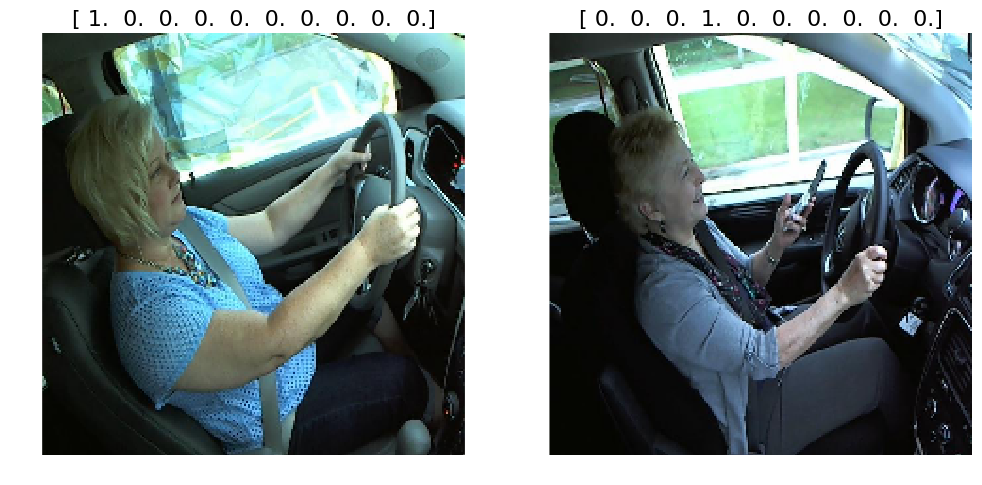

In [14]:
batches = vgg.get_batches(path+'train', batch_size=2)
imgs,labels = next(batches)
plots(imgs, titles=labels)
vgg.predict(imgs, True)

And two more...

(array([ 0.8648,  0.5782], dtype=float32),
 array([785, 785]),
 [u'seat_belt', u'seat_belt'])

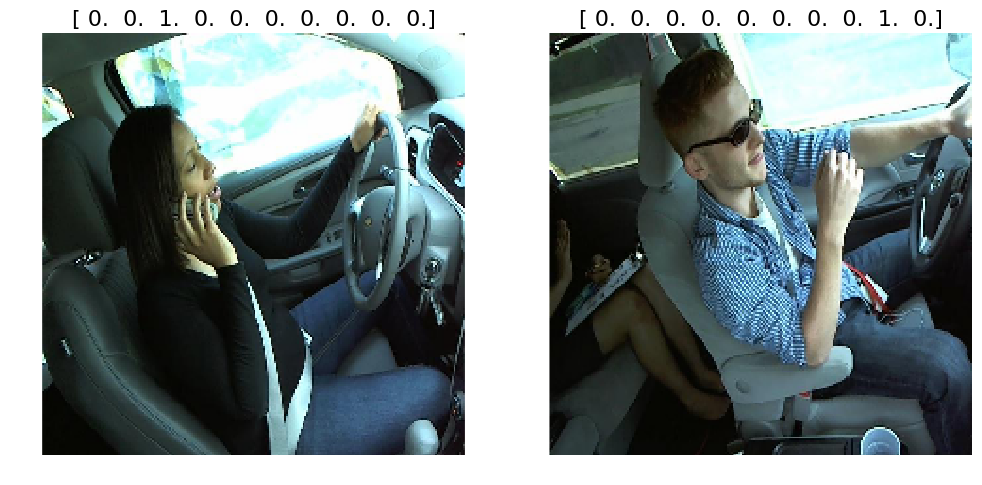

In [15]:
imgs,labels = next(batches)
plots(imgs, titles=labels)
vgg.predict(imgs, True)

The prediction values are not what I was expecting, with values like `seat_belt` and `barbershop`.
Let's try looking at a bigger batch of predictions, without images.

In [16]:
batches = vgg.get_batches(path+'train', batch_size=20)
imgs,labels = next(batches)
vgg.predict(imgs, True)

Found 18540 images belonging to 10 classes.


(array([ 0.7678,  0.5463,  0.8785,  0.9025,  0.7742,  0.819 ,  0.6821,  0.6402,  0.2167,  0.2916,
         0.8201,  0.9722,  0.8582,  0.7302,  0.4621,  0.6986,  0.7328,  0.8367,  0.8225,  0.765 ], dtype=float32),
 array([785, 785, 785, 785, 785, 785, 785, 785, 785, 785, 785, 785, 785, 785, 785, 785, 785, 785,
        785, 785]),
 [u'seat_belt',
  u'seat_belt',
  u'seat_belt',
  u'seat_belt',
  u'seat_belt',
  u'seat_belt',
  u'seat_belt',
  u'seat_belt',
  u'seat_belt',
  u'seat_belt',
  u'seat_belt',
  u'seat_belt',
  u'seat_belt',
  u'seat_belt',
  u'seat_belt',
  u'seat_belt',
  u'seat_belt',
  u'seat_belt',
  u'seat_belt',
  u'seat_belt'])

Vast majority of entries still seems to be `seat_belt`, but there's a bit more variation in the bigger batch with `golfcart` and `scuba_diver` making appearances. Still unclear to me what kind of categorization was going on here.

Let's take a peak at class names then.

In [17]:
vgg.classes[:4]

[u'tench', u'goldfish', u'great_white_shark', u'tiger_shark']

Oh, right. So I forgot that this is the very same Imagenet model from the Cats vs Dog competition. I had previously taken a look at that data, and it is quite specific in its categorization. So above, the model was looking at images of distracted drivers and seeing `seat_belt`s a lot - this makes more sense now. Moving on!

### Finetuning for State Farm

In [18]:
batches = vgg.get_batches(path + 'train', batch_size=batch_size)
val_batches = vgg.get_batches(path + 'valid', batch_size=batch_size)

Found 18540 images belonging to 10 classes.
Found 3884 images belonging to 10 classes.


In [19]:
vgg.finetune(batches)

In [20]:
vgg.fit(batches, val_batches, nb_epoch=1)

Epoch 1/1
18540/18540 [==============================] - 536s - loss: 1.9058 - acc: 0.4673 - val_loss: 1.5545 - val_acc: 0.5077


I'm curious how bumping up `nb_epoch` might affect accuracy...

In [21]:
vgg.fit(batches, val_batches, nb_epoch=2)

Epoch 1/2
18540/18540 [==============================] - 536s - loss: 1.0100 - acc: 0.6780 - val_loss: 1.3964 - val_acc: 0.5569
Epoch 2/2
18540/18540 [==============================] - 536s - loss: 0.8403 - acc: 0.7259 - val_loss: 1.5377 - val_acc: 0.5219


I believe that because I did not re-run `vgg.finetune` after the first `vgg.fit`, the above lines result in 3 epochs total.

Note the major increase in training accuracy and the moderate increate in validation accuracy between epochs.

More ideas on tweaks in the lesson discussion forum: http://forums.fast.ai/t/lesson-1-discussion/96/28

### Submission to Kaggle ([help](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/statefarm.ipynb))

_Note on file structure_: I needed to create a single 'unknown' class for the test set

In [22]:
from IPython.display import FileLink

subm_name = path + 'results/subm.gz'

In [23]:
#Get the classes from the training batch
classes = sorted(batches.class_indices, key=batches.class_indices.get)

In [24]:
batches, preds = vgg.test(path + 'test', batch_size = batch_size*2)

Found 79726 images belonging to 1 classes.


In [25]:
#For every image, vgg.test() generates two probabilities 
#based on how we've ordered the directories.
print preds[:5]

filenames = batches.filenames
print filenames[:5]

[[  5.4547e-02   1.3347e-02   2.8098e-04   1.1305e-03   3.8774e-03   2.2187e-01   3.3809e-01
    1.8020e-02   5.3176e-02   2.9566e-01]
 [  4.9513e-01   2.2126e-02   1.4309e-05   1.2463e-02   3.0805e-03   1.8996e-02   8.4261e-02
    7.0829e-02   2.8185e-01   1.1248e-02]
 [  2.1215e-03   3.5565e-05   3.5747e-02   2.3455e-02   7.6011e-01   2.6733e-03   8.1531e-02
    1.7742e-05   9.3924e-02   3.8982e-04]
 [  4.7212e-04   3.2254e-03   3.7290e-01   1.8506e-03   2.6274e-02   2.3715e-04   2.7530e-01
    9.3622e-03   3.0265e-01   7.7370e-03]
 [  3.5887e-03   2.3795e-03   2.1936e-03   1.4782e-04   1.0148e-02   2.1503e-02   5.9962e-01
    5.7799e-03   3.4969e-01   4.9495e-03]]
['unknown/img_81601.jpg', 'unknown/img_14887.jpg', 'unknown/img_62885.jpg', 'unknown/img_45125.jpg', 'unknown/img_22633.jpg']


In [27]:
submission = pd.DataFrame(preds, columns=classes)
submission.insert(0, 'img', [a[8:] for a in filenames])
submission.head()

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_81601.jpg,0.054547,0.013347,0.000281,0.001130,0.003877,0.221875,0.338087,0.018020,0.053176,0.295660
1,img_14887.jpg,0.495130,0.022126,0.000014,0.012463,0.003081,0.018996,0.084261,0.070829,0.281852,0.011248
2,img_62885.jpg,0.002121,0.000036,0.035747,0.023455,0.760105,0.002673,0.081531,0.000018,0.093924,0.000390
3,img_45125.jpg,0.000472,0.003225,0.372895,0.001851,0.026274,0.000237,0.275297,0.009362,0.302649,0.007737
4,img_22633.jpg,0.003589,0.002379,0.002194,0.000148,0.010148,0.021503,0.599620,0.005780,0.349690,0.004949


In [28]:
submission.to_csv(subm_name, index=False, compression='gzip')

In [29]:
FileLink(subm_name)

/home/ubuntu/hmwk/nbs/data/statefarm/results/subm.gz

Then, using the Kaggle CLI:
> `kg submit subm.gz -c state-farm-distracted-driver-detection`

My **multiclass loss** private score on submission is 1.72406. If this competition was still open, it would place me in the top 51.6% (743/1440). According to Jeremy, top 50% is an "ok-ish" model (and top 20% would be "very good"). This score was with nb_epoch = 1. No tweaks from what was taught in class.

My private score with 3 epochs is 1.45654 - an "ok-ish" top 45% (648/1440).